## Approach


#### Creating a RAG using LangChain
- using FAISS to create our vector database.
- In our database, we can’t dump the entire document as a whole, we need to break it into pieces so that we can search and find which part of the documents are relevant.
- retriever is a go-between that helps the vector database and the LLM communicate smoothly.

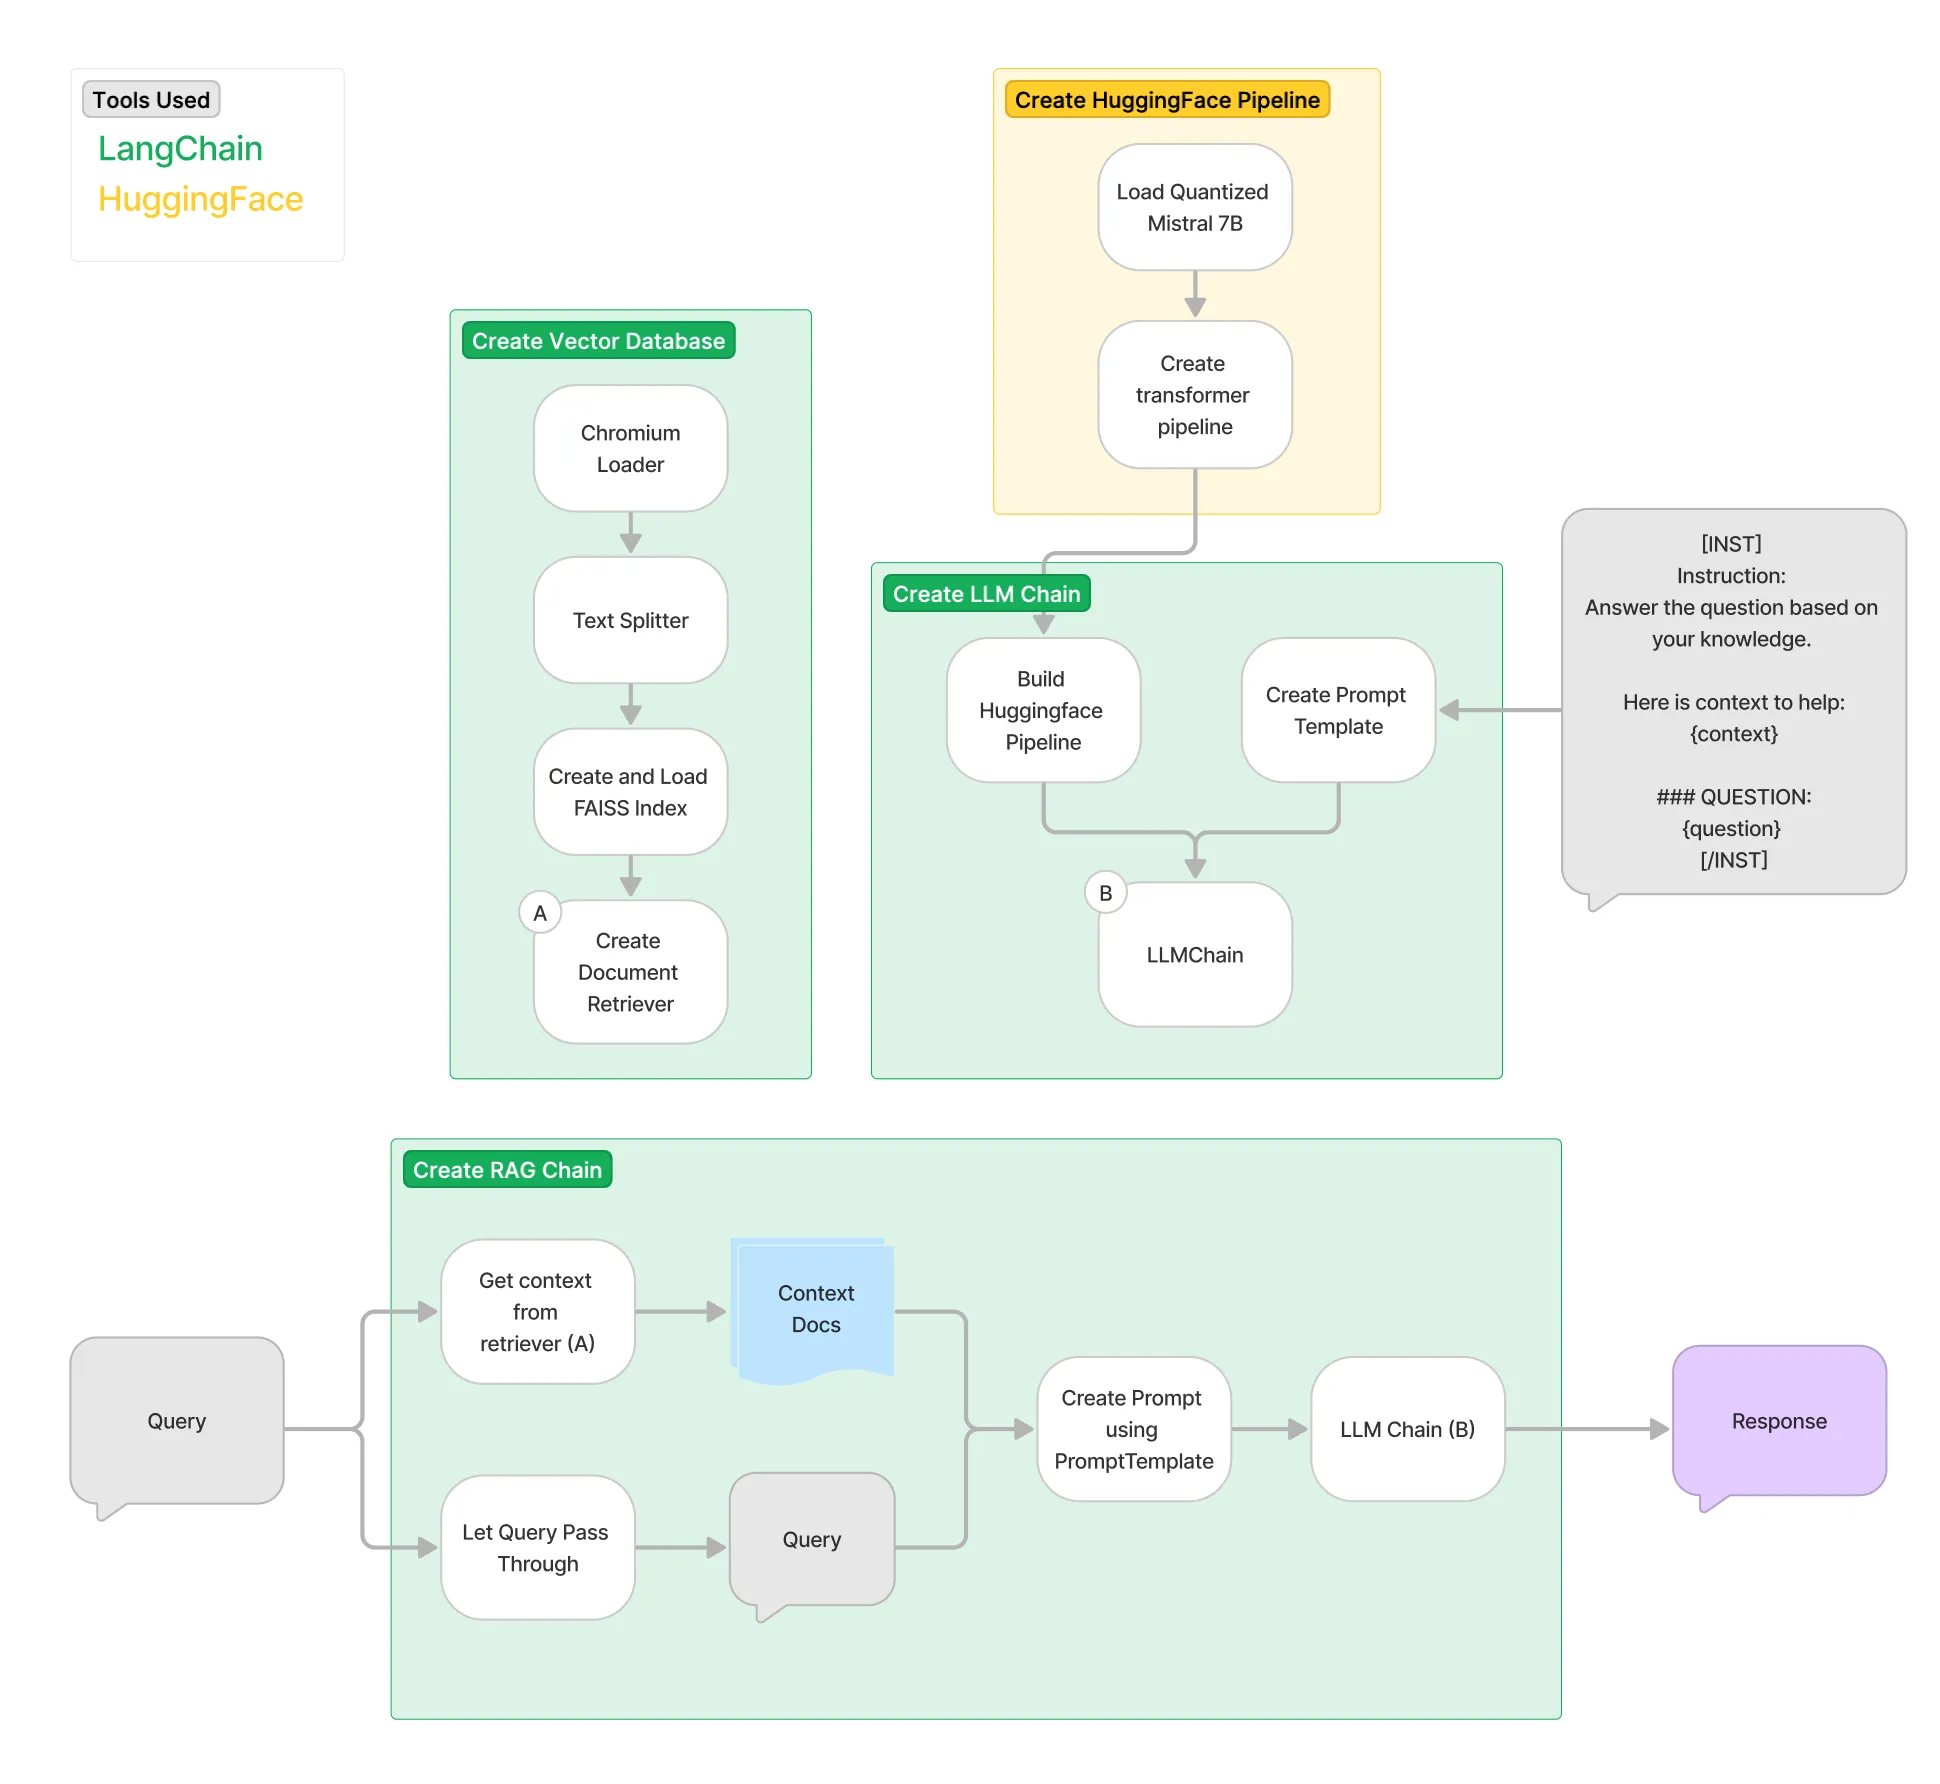

### Build RAG with Mistral-7B on articles 

In [ ]:
!pip install -q -U langchain playwright html2text sentence_transformers faiss-cpu
!pip install -q torch datasets
!pip install -q accelerate peft bitsandbytes trl

In [ ]:
import numpy as np 
import pandas as pd
import transformers
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline
)
from datasets import load_dataset
from peft import LoraConfig, PeftModel

from langchain.text_splitter import CharacterTextSplitter
from langchain.document_transformers import Html2TextTransformer
from langchain.document_loaders import AsyncChromiumLoader

from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain

In [ ]:
model_name = 'mistralai/Mistral-7B-Instruct-v0.1'

model_config = AutoConfig.from_pretrained(model_name)


tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code= True)

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'right'

In [ ]:
# bitsandbytes parameters


# Activate 4-bit precision 
use_4bit = True
# Compute dtype for 4-bit
bnb_4bit_compute_dtype = 'float16'
# Quantization type
bnb_4bit_quant_type = 'nf4'
# Activate nested quatization for 4-bit base model
use_nested_quant = False

In [ ]:
### Set up quantization config

compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit = use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)


In [ ]:
compute_dtype

In [ ]:
## Load pre-trained config

model = AutoModelForCausalLM.from_pretrained(model_name,
                    quantization_config = bnb_config)

In [ ]:
def print_number_of_trainable_parameters(model):
    """ return number of trainable parameters and total number of parameters
    
    input:
        model
    return:
        trainable parameters and total number of parameters
    """
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
        return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"
print(print_number_of_trainable_parameters(model))

## Build Mistral text Generation Pipeline

In [ ]:
text_generation_pipeline = pipeline(
    model = model,
    tokenizer = tokenizer,
    task = 'text-generation',
    temperature = 0.2,
    repetition_penalty = 1.1,
    return_full_text = True,
    max_new_tokens = 1000)

In [ ]:
mistral_llm = HuggingFacePipeline(pipeline = text_generation_pipeline)

#### Load and Chunk documents.Load chunked documents into FAISS index

In [ ]:
!playwright install 
!playwright install-deps 

In [ ]:
import nest_asyncio
nest_asyncio.apply()

articles = ["https://www.fantasypros.com/2023/11/rival-fantasy-nfl-week-10/",
            "https://www.fantasypros.com/2023/11/5-stats-to-know-before-setting-your-fantasy-lineup-week-10/",
            "https://www.fantasypros.com/2023/11/nfl-week-10-sleeper-picks-player-predictions-2023/",
            "https://www.fantasypros.com/2023/11/nfl-dfs-week-10-stacking-advice-picks-2023-fantasy-football/",
            "https://www.fantasypros.com/2023/11/players-to-buy-low-sell-high-trade-advice-2023-fantasy-football/"]

# scrapes the articles
loader = AsyncChromiumLoader(articles)
docs = loader.load()

In [ ]:
# convert HTML to plain text
html2text = Html2TextTransformer()
docs_transformed = html2text.transform_documents(docs)

# chunk text
text_splitter = CharacterTextSplitter(chunk_size = 100,
                                     chunk_overlap=0)

chunked_documnets = text_splitter.split_documents(docs_transformed)

# Load chunked documents into FAISS index
db = FAISS.from_documents(chunked_documnets,
                         HuggingFaceEmbeddings(model_name ='sentence-transformers/all-mpnet-base-v2'))

retriever = db.as_retriever()

## Create PromptTemplate and LLMChain

In [ ]:
prompt_template = """
### [INST] Instruction: Answer the question based on your fantasy football knowledge. Here is context to help:

{context}

### QUESTION:
{question} [/INST]
 """


# Create prompt from prompt template
prompt = PromptTemplate(
        input_variables = ['context', 'question'],
        template = prompt_template)

## Create llm chain
llm_chain = LLMChain(llm = mistral_llm, prompt= prompt)

## Build RAG Chain

In [ ]:
rag_chain = (
    {'context': retriever, 'question': RunnablePassthrough()}
    | llm_chain
)

result = rag_chain.invoke('what was the changes and a new strategy?')

In [ ]:
result['context']

In [ ]:
result['text']

# Table Question Answering

## Approach

Table Question Answering (Table QA) refers to providing precise answers from tables to answer a user's question.

#### Data
- subset of the Open Table-and-Text Question Answering (OTT-QA) dataset. 
- consisting of texts and tables from Wikipedia. 
- The subset contains 20,000 tables, and it can be loaded from the Huggigface Datasets hub.

#### Steps

- Vector index to store table embeddings
- Retriever model for embedding queries and tables
- Reader model to read the tables and extract answers

In [20]:
!pip install pinecone-client torch-scatter

  Obtaining dependency information for pinecone-client from https://files.pythonhosted.org/packages/df/d4/cffbb61236c6c1d7510e835c1ff843e4e7d705ed59d21c0e5b6dc1cb4fd8/pinecone_client-2.2.4-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for loguru>=0.5.0 from https://files.pythonhosted.org/packages/03/0a/4f6fed21aa246c6b49b561ca55facacc2a44b87d65b8b92362a8e99ba202/loguru-0.7.2-py3-none-any.whl.metadata
  Obtaining dependency information for dnspython>=2.0.0 from https://files.pythonhosted.org/packages/f6/b4/0a9bee52c50f226a3cbfb54263d02bb421c7f2adc136520729c2c689c1e5/dnspython-2.4.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.4/179.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.1 MB/s eta 0:00:00
  Created

## Load the Dataset

In [18]:
# !pip install -U datasets
# !pip install sentence_transformers 

ERROR: Could not find a version that satisfies the requirement pinecone (from versions: none)
ERROR: No matching distribution found for pinecone


In [1]:
from datasets import load_dataset

dataset = load_dataset('ashraq/ott-qa-20k')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'title', 'header', 'data', 'section_title', 'section_text', 'uid', 'intro'],
        num_rows: 20000
    })
})

In [12]:
import pandas as pd

tables = []
for doc in dataset['train']:
    table = pd.DataFrame(doc['data'], columns=doc['header'])
    tables.append(table)

In [24]:
tables[1]

,Position,Player,Club
0,GK,Vincent Demarconnay,Paris FC
1,RB,Fabien Centonze,Lens
2,CB,Stoppila Sunzu,Metz
3,CB,John Boye,Metz
4,LB,Thomas Delaine,Metz
5,CM,Farid Boulaya,Metz
6,CM,Renaud Cohade,Metz
7,CM,Alexis Claude-Maurice,Lorient
8,FW,Opa Nguette,Metz
9,FW,Gaëtan Charbonnier,Brest


## Initialize Retriever

Generate embeddings in a way that the natural language questions and tables containing answers to our questions are nearby in the vector space.

In [26]:
import torch
from sentence_transformers import SentenceTransformer

device = 'cuda' if torch.cuda.is_available() else 'cpu'

retriever = SentenceTransformer('deepset/all-mpnet-base-v2-table', device = device)
retriever

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [27]:
retriever

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [10]:
def _preprocess_tables(tables: list):
    """ Convert the tables in a format that the retriever expect
    
    input:
        tables
    return:
        converted tables
    """
    processed = []
    for table in tables:
        # convert table to csv
        processed_table = '\n'.join([table.to_csv(index=False)])
        processed.append(processed_table)
    return processed

In [15]:
# format all the dataframes in the tables list
processed_tables = _preprocess_tables(tables)
processed_tables[2]

'Level,Team,League,Manager\nAAA,Tidewater Tides,International League,Tom Burgess\nAA,Jackson Mets,Texas League,John Antonelli\nA,Lynchburg Mets,Carolina League,Jack Aker\nA,Wausau Mets,Midwest League,Bill Monbouquette\nRookie,Marion Mets,Appalachian League,Al Jackson\n'

## Initialize Pinecone Index

The Pinecone index stores vector representations of our tables which we can retrieve using a natural language query (query vector). Pinecone does this by computing the similarity between the query vector and the embedded tables stored in the vector index.

In [21]:
import pinecone

# connect to pinecone environment
pinecone.init(
    api_key = '7ee715ce-3fd9-4864-a657-d08d4df3f8ad',
    environment= 'us-west1-gcp')

In [22]:
index_name = 'table-qa'

# check if 'table_qa'index exist
if index_name not in pinecone.list_indexes():
    pinecone.create_index(
            index_name,
            dimension = 768,
            metric = 'cosine')
    
# connect to table-qa
index = pinecone.Index(index_name)

## Generate Embeddings and Upsert

In [28]:
from tqdm.auto import tqdm

batch_size = 64

for i in tqdm(range(0, len(processed_tables), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(processed_tables))
    # extract batch
    batch = processed_tables[i:i_end]
    # generate embeddings 
    embd = retiever.encode(batch).tolist()
    # create IDs ranging from 0 to number of tables
    ids = [f'{idx}' for idx in range(i, i_end)]
    to_upsert = list(zip(ids, embd))
    # insert  these records to pinecone
    _ = index.upsert(vectors = to_upsert)
    
# check if all the vectors exist
index.describe_index_stats()

  0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 20000}},
 'total_vector_count': 20000}

In [29]:
query = 'whcih counrty has the highest GDP in 2020?'

# generate embedding for the query
q_embd = retriever.encode([query]).tolist()
# query pinecone index to find the table containing the answer
result = index.query(q_embd, top_k = 1)
result

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'matches': [{'id': '19931', 'score': 0.74107188, 'values': []}],
 'namespace': ''}

The Pinecone index has returned the id of a table that would contain the answer to our query with 82.2% confidence.

In [30]:
id = int(result['matches'][0]['id'])
tables[id].head()

,Rank,Country,"GDP ( PPP , Peak Year ) millions of USD",Peak Year
0,1,China,"27,804,953",2020
1,2,India,"11,321,280",2020
2,3,Russia,"4,389,960",2019
3,4,Indonesia,"3,778,134",2020
4,5,Brazil,"3,596,841",2020


## Initialize Table Reader

TAPAS model fine-tuned for the Table QA task. TAPAS is a BERT-like Transformer model pretrained in a self-supervised manner on a large corpus of English language data from Wikipedia.

In [31]:
from transformers import pipeline, TapasTokenizer, TapasForQuestionAnswering

model_name = 'google/tapas-base-finetuned-wtq'

tokenizer = TapasTokenizer.from_pretrained(model_name)
model = TapasForQuestionAnswering.from_pretrained(model_name)

pipe = pipeline('table-question-answering', model=model, tokenizer = tokenizer, device = device)

tokenizer_config.json:   0%|          | 0.00/490 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/262k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/154 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [32]:
pipe(table=tables[id], query=query)

/opt/conda/lib/python3.10/site-packages/transformers/models/tapas/tokenization_tapas.py:2762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/conda/lib/python3.10/site-packages/transformers/models/tapas/tokenization_tapas.py:1561: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]


{'answer': 'China',
 'coordinates': [(0, 1)],
 'cells': ['China'],
 'aggregator': 'NONE'}

## Querying

(query_pinecone, get_answer_from_table) functions to handle our queries and extract answers from tables.

In [33]:
def query_pinecone(query):
    # generate embedding for the query
    xq = retriever.encode([query]).tolist()
    # query pinecone index to find the table containing answer to the query
    result = index.query(xq, top_k=1)
    # return the relevant table from the tables list
    return tables[int(result["matches"][0]["id"])]

In [34]:
def get_answer_from_table(table, query):
    # run the table and query through the question-answering pipeline
    answers  = pipe(table = table, query = query)
    return answers

In [35]:
query = "which car manufacturers produce cars with a top speed of above 180 kph?"
table = query_pinecone(query)
table

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,Manufacturer,Model,Engine,Power Output,Max . Speed ( kph ),Dry Weight ( kg )
0,Fiat,805-405,FIAT 1979cc S6 supercharged,130 bhp,220,680
1,Alfa Romeo,GPR ( P1 ),Alfa Romeo 1990cc S6,95 bhp,180,850
2,Diatto,Tipo 20 S,Diatto 1997cc S4,75 bhp,155,700
3,Bugatti,Type 32,Bugatti 1991cc S8,100 bhp,190,660
4,Voisin,C6 Laboratoire,Voisin 1978cc S6,90 bhp,175,710
5,Sunbeam,,Sunbeam 1988cc S6,108 bhp,180,675
6,Mercedes,M7294,Mercedes 1990cc S4 supercharged,120 bhp,180,750
7,Benz,RH Tropfenwagen,Benz 1998cc S6,95 bhp,185,745
8,Miller,122,Miller 1978cc S8,120 bhp,186,850


In [36]:
get_answer_from_table(table, query)

/opt/conda/lib/python3.10/site-packages/transformers/models/tapas/tokenization_tapas.py:2762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/opt/conda/lib/python3.10/site-packages/transformers/models/tapas/tokenization_tapas.py:1561: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]


{'answer': 'Fiat, Bugatti, Benz, Miller',
 'coordinates': [(0, 0), (3, 0), (7, 0), (8, 0)],
 'cells': ['Fiat', 'Bugatti', 'Benz', 'Miller'],
 'aggregator': 'NONE'}